In [1]:
import requests
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pathlib
import tarfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-02-04 14:20:48.658360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
url = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"
r = requests.get(url, allow_redirects=True)
open("cora.tgz", "wb").write(r.content)

168052

In [3]:
tarball_path = pathlib.Path("datasets/housing.tgz")
if not tarball_path.is_file():
    pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
    with tarfile.open("cora.tgz") as datafile:
        datafile.extractall(path="datasets")
citationdata = pd.read_csv(pathlib.Path("datasets/cora/cora.cites"), sep="\t",header=None, names=["target", "source"],)
citationdata.sample(frac=1)

,target,source
2609,28336,108047
3628,74937,74920
5414,817774,820661
1506,7419,1113182
4197,136768,136766
...,...,...
3915,97390,33907
4086,123825,42847
2994,38845,1107010
157,35,81722


In [4]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
paperdata = pd.read_csv(pathlib.Path("datasets/cora/cora.content"), sep="\t", header=None, names=column_names,)
paperdata.shape

(2708, 1435)

In [5]:
paperdata.sample(20)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
1941,126926,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
1622,1000012,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rule_Learning
1432,1107674,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
196,232606,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rule_Learning
2684,115188,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
1963,55403,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rule_Learning
2285,643695,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
592,648112,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
2206,593942,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2697,626530,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [6]:
paperdata[["subject"]].value_counts()

subject               
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
dtype: int64

In [7]:
class_values = sorted(paperdata["subject"].unique())
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [8]:
class_idx = {name: id for id, name in enumerate(class_values)}
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [9]:
paper_idx = {name: idx for idx, name in enumerate(sorted(paperdata["paper_id"].unique()))}
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

In [10]:
paperdata["paper_id"] = paperdata["paper_id"].apply(lambda name: paper_idx[name])
paperdata["subject"] = paperdata["subject"].apply(lambda value: class_idx[value])
citationdata["source"] = citationdata["source"].apply(lambda name: paper_idx[name])
citationdata["target"] = citationdata["target"].apply(lambda name: paper_idx[name])

In [11]:
paperdata.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [12]:
plt.figure(figsize=(10,10))
colors = paperdata["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citationdata.sample(n=150))
subjects = list(paperdata[paperdata["paper_id"].isin(list(cora_graph.nodes))]["subject"])
subjects

[0,
 4,
 4,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 3,
 6,
 0,
 3,
 3,
 2,
 2,
 2,
 6,
 2,
 3,
 2,
 6,
 1,
 2,
 5,
 6,
 1,
 2,
 4,
 0,
 0,
 2,
 0,
 2,
 0,
 3,
 0,
 1,
 4,
 5,
 4,
 3,
 2,
 6,
 5,
 1,
 3,
 5,
 6,
 2,
 1,
 5,
 2,
 6,
 6,
 4,
 3,
 0,
 4,
 2,
 2,
 4,
 4,
 6,
 2,
 0,
 0,
 4,
 2,
 4,
 3,
 2,
 0,
 6,
 3,
 5,
 2,
 6,
 4,
 1,
 3,
 2,
 2,
 2,
 5,
 2,
 2,
 1,
 4,
 2,
 0,
 2,
 0,
 3,
 2,
 4,
 2,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 6,
 2,
 6,
 3,
 3,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 6,
 5,
 4,
 6,
 4,
 4,
 1,
 2,
 2,
 3,
 3,
 2,
 2,
 1,
 1,
 5,
 6,
 6,
 1,
 5,
 1,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 0,
 1,
 4,
 2,
 6,
 2,
 3,
 6,
 0,
 4,
 4,
 2,
 2,
 2,
 0,
 2,
 6,
 3,
 0,
 5,
 2,
 2,
 2,
 4,
 1,
 1,
 1,
 3,
 3,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 1,
 6,
 4,
 1,
 1,
 4,
 3,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 3,
 3,
 4,
 6,
 1,
 6,
 4,
 6,
 3,
 2,
 2,
 0,
 0,
 3,
 1,
 2,
 1,
 2,
 0,
 2,
 4,
 3,
 4,
 1,
 5,
 2,
 2,
 5,
 2,
 0,
 1,
 2,
 2,
 0,
 5,
 1,
 2,
 3,
 6,
 6,
 6,
 1,
 2,
 2,
 0,
 3,
 2,
 2,
 2,
 2,


<Figure size 1000x1000 with 0 Axes>

In [13]:
#nx.draw_spring(cora_graph, node_size = 15, node_colour = subjects)

In [14]:
#nx.drawing.layout.spring_layout(cora_graph)

In [15]:
paperdata.groupby("subject")

In [16]:
train_data, test_data = [], []

for _, group_data in paperdata.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2155, 1435)
Test data shape: (553, 1435)


In [17]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 256

In [18]:
def run_exp(model, x_train, y_train):
    model.compile(optimizer = keras.optimizers.Adam(learning_rate), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")])
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
    history = model.fit(x=x_train,y=y_train,epochs=num_epochs,batch_size=batch_size,validation_split=0.15,callbacks=[early_stopping])
    return history

In [19]:
def plot_learning_curve(history):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [20]:
def createffn(hidden_units, dropout_rate, name=None):
    fnnlayers = []
    for units in hidden_units:
        fnnlayers.append(layers.BatchNormalization())
        fnnlayers.append(layers.Dropout(dropout_rate))
        fnnlayers.append(layers.Dense(units, activation=tf.nn.gelu))
    return keras.Sequential(fnnlayers, name=name)

In [21]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [22]:
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

In [23]:
featurenames = set(paperdata.columns) - {"paper_id","subject"}
nfeatures = len(featurenames)
nclasses = len(class_idx)
x_train = train_data[featurenames].to_numpy()
x_test = test_data[featurenames].to_numpy()

y_train = train_data["subject"]
y_test = test_data["subject"]


/tmp/ipykernel_296/362588152.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[featurenames].to_numpy()
/tmp/ipykernel_296/362588152.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[featurenames].to_numpy()


In [24]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(nfeatures,), name="input_features")
    x = createffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = createffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, nclasses, dropout_rate)
baseline_model.summary()

2023-02-04 14:21:03.774786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 14:21:03.778855: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [34]:
history = run_exp(baseline_model, x_train, y_train)

Epoch 1/100
8/8 [==============================] - 5s 130ms/step - loss: 0.6124 - acc: 0.7914 - val_loss: 0.6156 - val_acc: 0.7901
Epoch 2/100
8/8 [==============================] - 0s 55ms/step - loss: 0.6076 - acc: 0.7837 - val_loss: 0.5966 - val_acc: 0.7932
Epoch 3/100
8/8 [==============================] - 0s 55ms/step - loss: 0.5916 - acc: 0.7985 - val_loss: 0.5854 - val_acc: 0.7994
Epoch 4/100
8/8 [==============================] - 1s 63ms/step - loss: 0.5722 - acc: 0.7957 - val_loss: 0.6136 - val_acc: 0.7809
Epoch 5/100
8/8 [==============================] - 0s 44ms/step - loss: 0.6054 - acc: 0.7870 - val_loss: 0.6248 - val_acc: 0.7747
Epoch 6/100
8/8 [==============================] - 0s 48ms/step - loss: 0.5730 - acc: 0.7957 - val_loss: 0.6296 - val_acc: 0.7963
Epoch 7/100
8/8 [==============================] - 0s 45ms/step - loss: 0.5941 - acc: 0.7848 - val_loss: 0.6272 - val_acc: 0.7901
Epoch 8/100
8/8 [==============================] - 0s 60ms/step - loss: 0.5766 - acc: 0.8

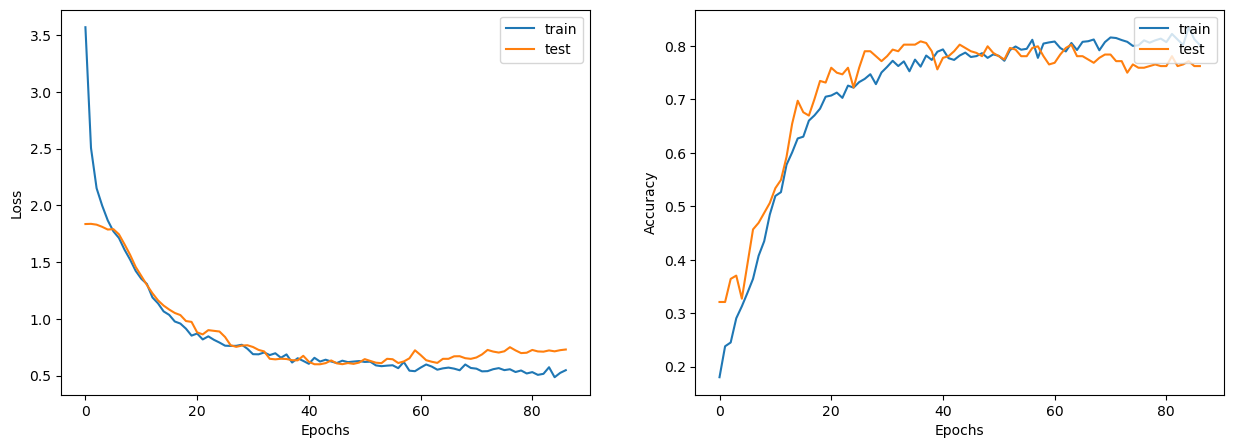

In [26]:
plot_learning_curve(history)

In [27]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 75.77%


In [28]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)

def display_class_probabilities(probabilities):
     for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [35]:
new_instances = generate_random_instances(10)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 420ms/step
Instance 1:
- Case_Based: 3.48%
- Genetic_Algorithms: 0.59%
- Neural_Networks: 2.52%
- Probabilistic_Methods: 1.11%
- Reinforcement_Learning: 0.53%
- Rule_Learning: 1.72%
- Theory: 90.05%
Instance 2:
- Case_Based: 3.91%
- Genetic_Algorithms: 4.38%
- Neural_Networks: 17.38%
- Probabilistic_Methods: 35.29%
- Reinforcement_Learning: 24.84%
- Rule_Learning: 7.07%
- Theory: 7.12%
Instance 3:
- Case_Based: 11.01%
- Genetic_Algorithms: 7.32%
- Neural_Networks: 18.86%
- Probabilistic_Methods: 0.84%
- Reinforcement_Learning: 0.56%
- Rule_Learning: 31.55%
- Theory: 29.86%
Instance 4:
- Case_Based: 0.24%
- Genetic_Algorithms: 1.13%
- Neural_Networks: 94.49%
- Probabilistic_Methods: 1.33%
- Reinforcement_Learning: 0.45%
- Rule_Learning: 0.8%
- Theory: 1.56%
Instance 5:
- Case_Based: 2.59%
- Genetic_Algorithms: 2.88%
- Neural_Networks: 13.89%
- Probabilistic_Methods: 3.69%
- Reinforcement_Learning: 59.39%
- Rule_Learning: 4.54%
- Theory: 13.02%
I

In [30]:
new_instances.shape

(10, 1433)